In [1]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%reload_ext version_information
%version_information numpy, scipy, matplotlib, pandas

/home/ubuntu/anaconda2/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed version_information.py. To use it, type:
  %load_ext version_information


Software versions
Python 2.7.11 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.1.2
OS Linux 3.13.0 74 generic x86_64 with debian jessie sid
numpy 1.10.4
scipy 0.17.0
matplotlib 1.5.1
pandas 0.18.0
Fri Jun 10 04:31:04 2016 UTC

In [2]:
# Couldn't find what to do with 'magic' imports at the top

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina' 

# Add this to python2 code to make life easier
from __future__ import absolute_import, division, print_function

from itertools import combinations
import string

from IPython.display import IFrame, HTML, YouTubeVideo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy.sparse import vstack, hstack
sns.set();
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.3)

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [4]:
from feature_union import feature_union, DenseTransformer

In [5]:
# talk to postgresql
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd

In [6]:
qa = pd.read_pickle("./extracted.2016-03-06.pkl")
qa.shape

(1535, 9)

In [7]:
qa.posttypeid.value_counts()

2    805
1    730
Name: posttypeid, dtype: int64

In [8]:
qa.head(1)

,title,paragraphs,id,posttypeid,acceptedanswerid,creationdate,tags,parentid,codes
0,using javascript to change text on a window re...,the problem at the moment is that when the win...,35821438,1,NaN,2016-03-06 00:00:05.190,javascript jquery html,NaN,var myspan = document.getElementById('players-...


# Posts

- Id
- PostTypeId (listed in the PostTypes table)
  - Question (1)
  - Answer (2)
  - Orphaned tag wiki
  - Tag wiki excerpt
  - Tag wiki
  - Moderator nomination
  - "Wiki placeholder" (seems to only be the election description)
  - Privilege wiki
- AcceptedAnswerId (only present if PostTypeId is 1)
- ParentID (only present if PostTypeId is 2)
- CreationDate
- DeletionDate (only non-null for the SEDE PostsWithDeleted table. Deleted posts are not present on Posts. Column not present on data dump.)
- Score
- ViewCount (nullable)
- Body (as rendered HTML, not Markdown)
- OwnerUserId (only present if user has not been deleted; always -1 for tag wiki entries, i.e. the community user owns them)
- OwnerDisplayName (nullable)
- LastEditorUserId (nullable)
- LastEditorDisplayName (nullable)
- LastEditDate="2009-03-05T22:28:34.823" - the date and time of the most recent edit to the post (nullable)
- LastActivityDate="2009-03-11T12:51:01.480" - the date and time of the most recent activity on the post. For a question, this could be the post being edited, a new answer was posted, a bounty was started, etc.
- Title (nullable)
- Tags (nullable)
- AnswerCount (nullable)
- CommentCount
- FavoriteCount
- ClosedDate (present only if the post is closed)
- CommunityOwnedDate (present only if post is community wikied)

In [9]:
questions_ids = qa[qa['posttypeid'] == 1]['id']
questions_ids.shape

(730,)

In [10]:
qa['hasCodes'] = qa.codes.apply(lambda c: 0 if c is None else 1)

In [11]:
answers = qa[qa.posttypeid == 2]

In [12]:
answers.head(1)

,title,paragraphs,id,posttypeid,acceptedanswerid,creationdate,tags,parentid,codes,hasCodes
2,None,"IN ( '>= 03/04/2016', '') does not retrieve a ...",35821440,2,NaN,2016-03-06 00:00:32.833,None,3.58088e+07,None,0


In [13]:
questions_answered_ids = questions_ids[questions_ids.isin(answers.parentid)]

In [14]:
questions_unanswered_ids = questions_ids[~questions_ids.isin(answers.parentid)]

## Classify whether a question shall be answered within 1 week

In [15]:
questions = qa[qa['id'].isin(questions_ids)]

In [16]:
answered_q = questions[questions['id'].isin(questions_answered_ids)]

In [17]:
q_a = pd.merge(answered_q, answers, left_on='id', right_on='parentid')

In [18]:
q_a['ElapsedTime'] = (q_a.creationdate_y - q_a.creationdate_x).astype('timedelta64[m]')

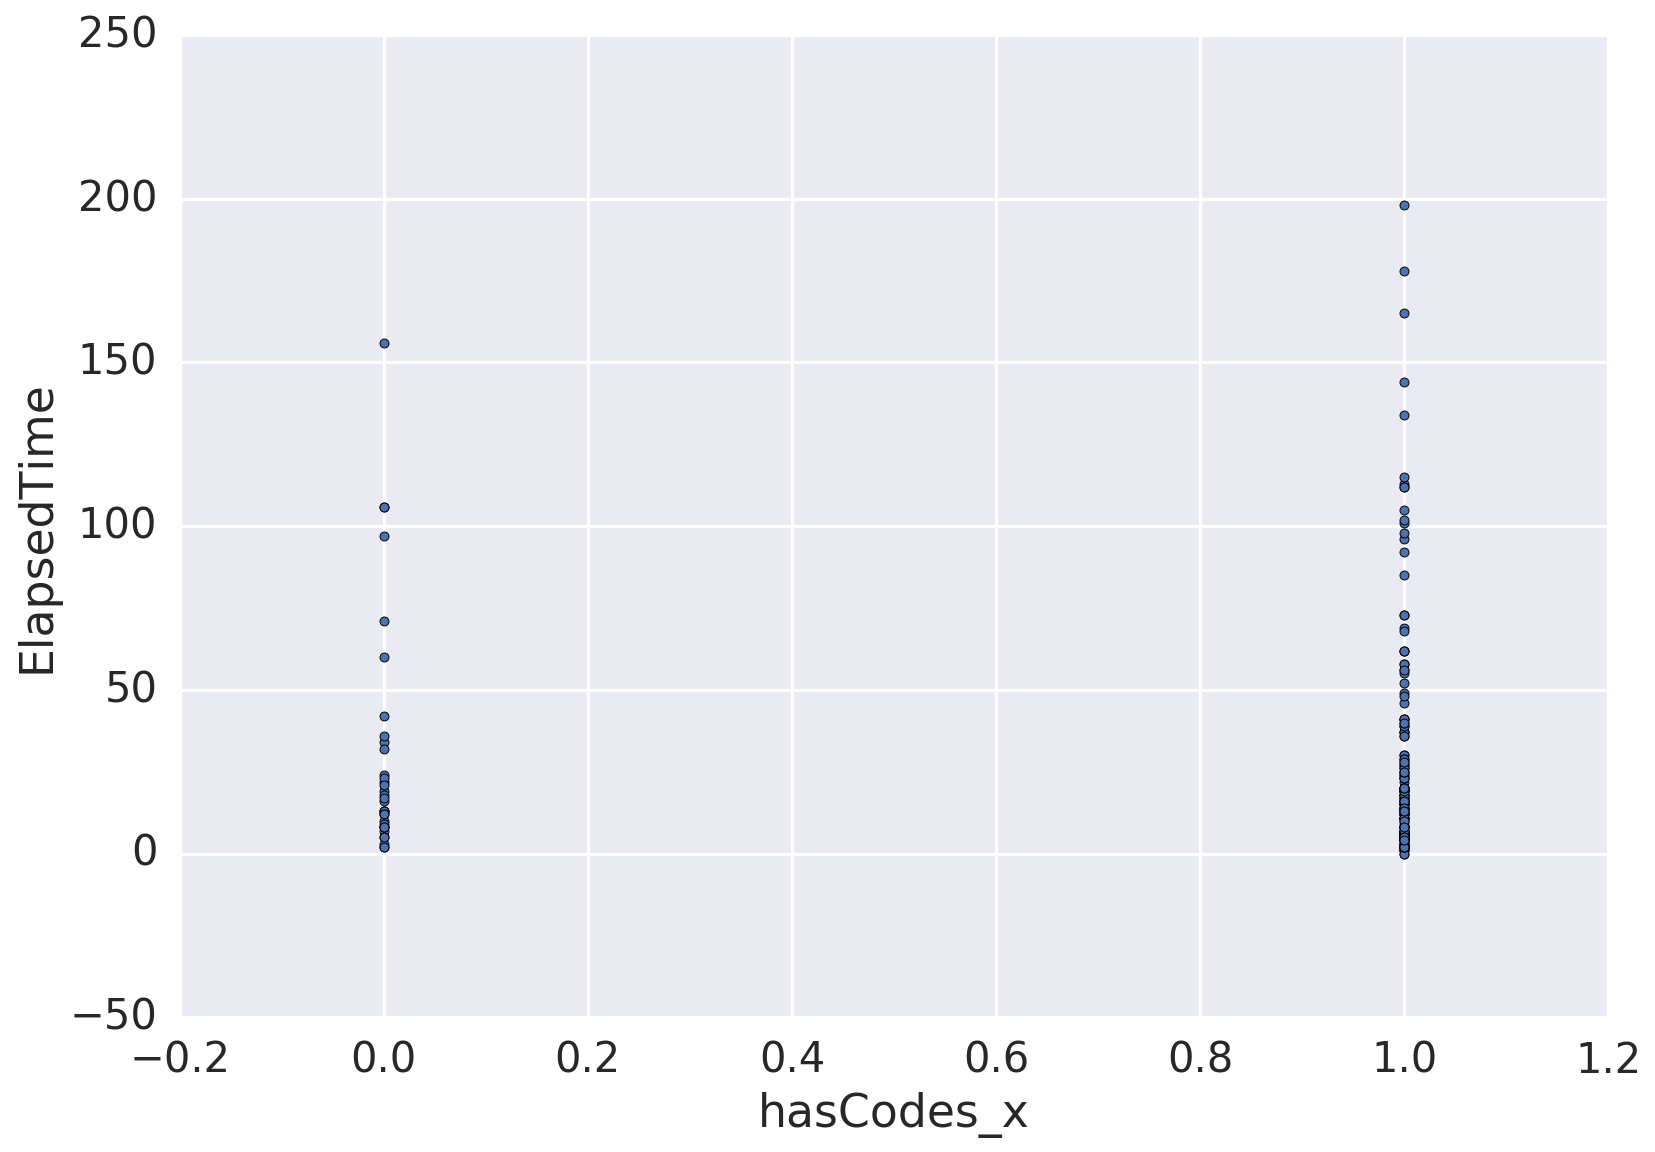

In [19]:
q_a.sample(200).plot(kind='scatter', x='hasCodes_x', y='ElapsedTime')

In [20]:
shortest_elapsed_time = q_a.groupby('id_x').apply(lambda g: g['ElapsedTime'].min())

In [21]:
print("One week = {} min".format(24 * 60 * 7))

One week = 10080 min


In [22]:
questions_answered_late_ids = shortest_elapsed_time[shortest_elapsed_time > 10080].index

In [23]:
failed_questions_ids = np.concatenate((questions_unanswered_ids.values, questions_answered_late_ids))

In [24]:
failed_questions_ids.shape

(428,)

In [25]:
questions['success'] = questions['id'].isin(failed_questions_ids).apply(lambda b: 0 if b else 1)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
questions.head(1)

,title,paragraphs,id,posttypeid,acceptedanswerid,creationdate,tags,parentid,codes,hasCodes,success
0,using javascript to change text on a window re...,the problem at the moment is that when the win...,35821438,1,NaN,2016-03-06 00:00:05.190,javascript jquery html,NaN,var myspan = document.getElementById('players-...,1,0


In [27]:
feature_cols = ['title', 'paragraphs', 'tags', 'hasCodes']

In [28]:
cls_df = questions[feature_cols + ['success']]

In [29]:
cls_df.head()

,title,paragraphs,tags,hasCodes,success
0,using javascript to change text on a window re...,the problem at the moment is that when the win...,javascript jquery html,1,0
1,GNUMake link step not work for certain libraries,I can't figure out why my binary does not link...,linker gnu-make gnu ld,1,1
3,Javascript cannot unhide element after cloning?,I'm working on something where multiple functi...,javascript html dom asynchronous,1,1
6,Why is my onclick event not executing?,I have a simple button that executes a javascr...,javascript html,1,1
7,Verifying signature of a file using the certif...,I am totally new to security and signature ver...,java security bouncycastle verification p...,0,1


In [30]:
cls_train = cls_df.sample(int(cls_df.shape[0] / 2))

In [31]:
cls_test = cls_df[~cls_df.index.isin(cls_train.index)]

### Logistic regression

In [32]:
pipeline = Pipeline(feature_union + [
#        ('to_dense', DenseTransformer()),
       ('cls', LogisticRegression()),
        
    ])

In [33]:
pipeline.fit(cls_train[feature_cols], cls_train['success'])
y = pipeline.predict(cls_test[feature_cols])
print(classification_report(y, cls_test['success']))

             precision    recall  f1-score   support

          0       0.97      0.54      0.69       359
          1       0.01      0.17      0.01         6

avg / total       0.96      0.53      0.68       365



In [34]:
joblib.dump(pipeline, "./logistic_regression.pkl")

['./logistic_regression.pkl',
 './logistic_regression.pkl_01.npy',
 './logistic_regression.pkl_02.npy',
 './logistic_regression.pkl_03.npy',
 './logistic_regression.pkl_04.npy',
 './logistic_regression.pkl_05.npy',
 './logistic_regression.pkl_06.npy',
 './logistic_regression.pkl_07.npy',
 './logistic_regression.pkl_08.npy',
 './logistic_regression.pkl_09.npy',
 './logistic_regression.pkl_10.npy']

In [35]:
random_guesses = cls_df.success.sample(cls_test.shape[0])

In [36]:
print(classification_report(random_guesses, cls_test['success']))

             precision    recall  f1-score   support

          0       0.54      0.53      0.54       202
          1       0.43      0.44      0.44       163

avg / total       0.49      0.49      0.49       365



In [37]:
scores = pipeline.decision_function(cls_test[feature_cols])
fpr, tpr, thresholds = metrics.roc_curve(cls_test['success'], scores, pos_label=1)

Area under curve is 0.629680033872


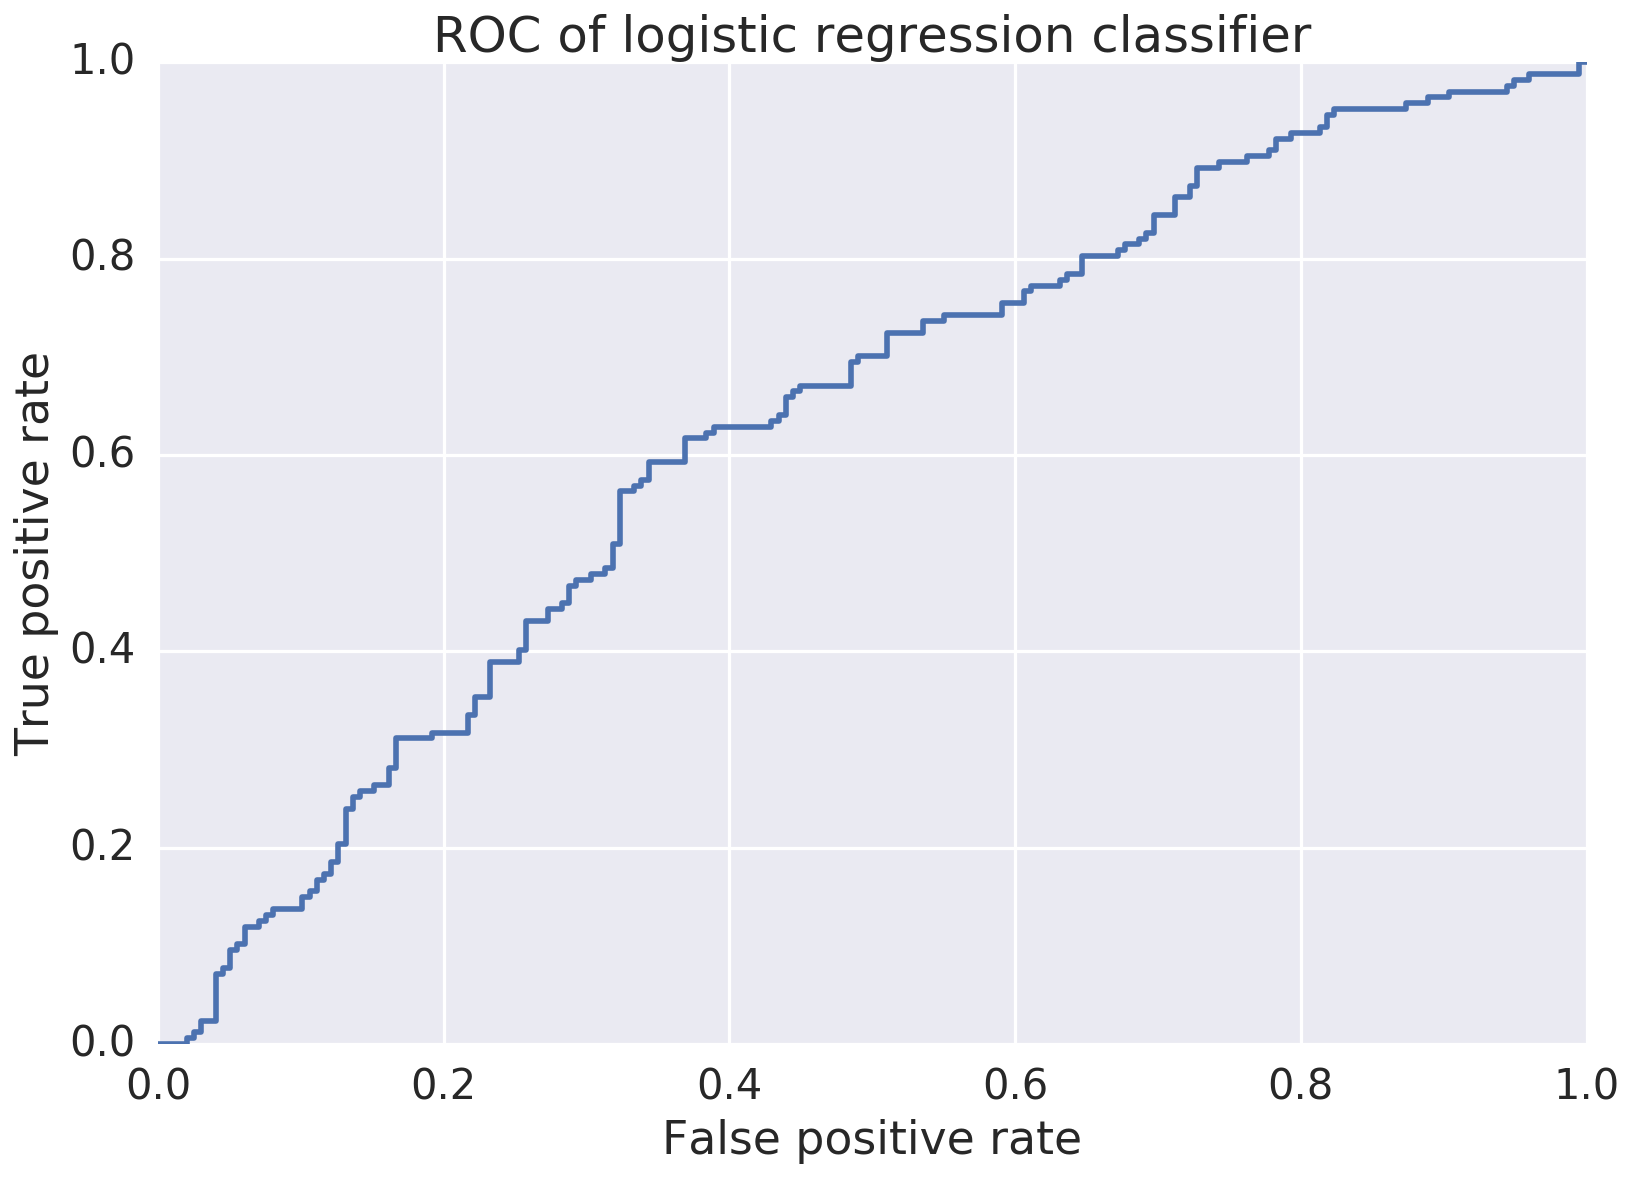

In [38]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig("./logistic_regression_roc.png")
plt.title("ROC of logistic regression classifier")
print("Area under curve is {}".format(metrics.auc(fpr, tpr)))

### Random Forest

In [39]:
pipeline = Pipeline(feature_union + [
#        ('to_dense', DenseTransformer()),
        ('cls', RandomForestClassifier(n_jobs=4, class_weight='balanced')),
    ])
pipeline.fit(cls_train[feature_cols], cls_train['success'])
y = pipeline.predict(cls_test[feature_cols])
print(classification_report(y, cls_test['success']))

             precision    recall  f1-score   support

          0       0.81      0.54      0.64       299
          1       0.17      0.42      0.24        66

avg / total       0.69      0.52      0.57       365



In [40]:
scores = pipeline.predict_proba(cls_test[feature_cols])

In [41]:
fpr, tpr, thresholds = metrics.roc_curve(cls_test['success'], scores[:, 1], pos_label=1)

Area under curve is 0.527581201234


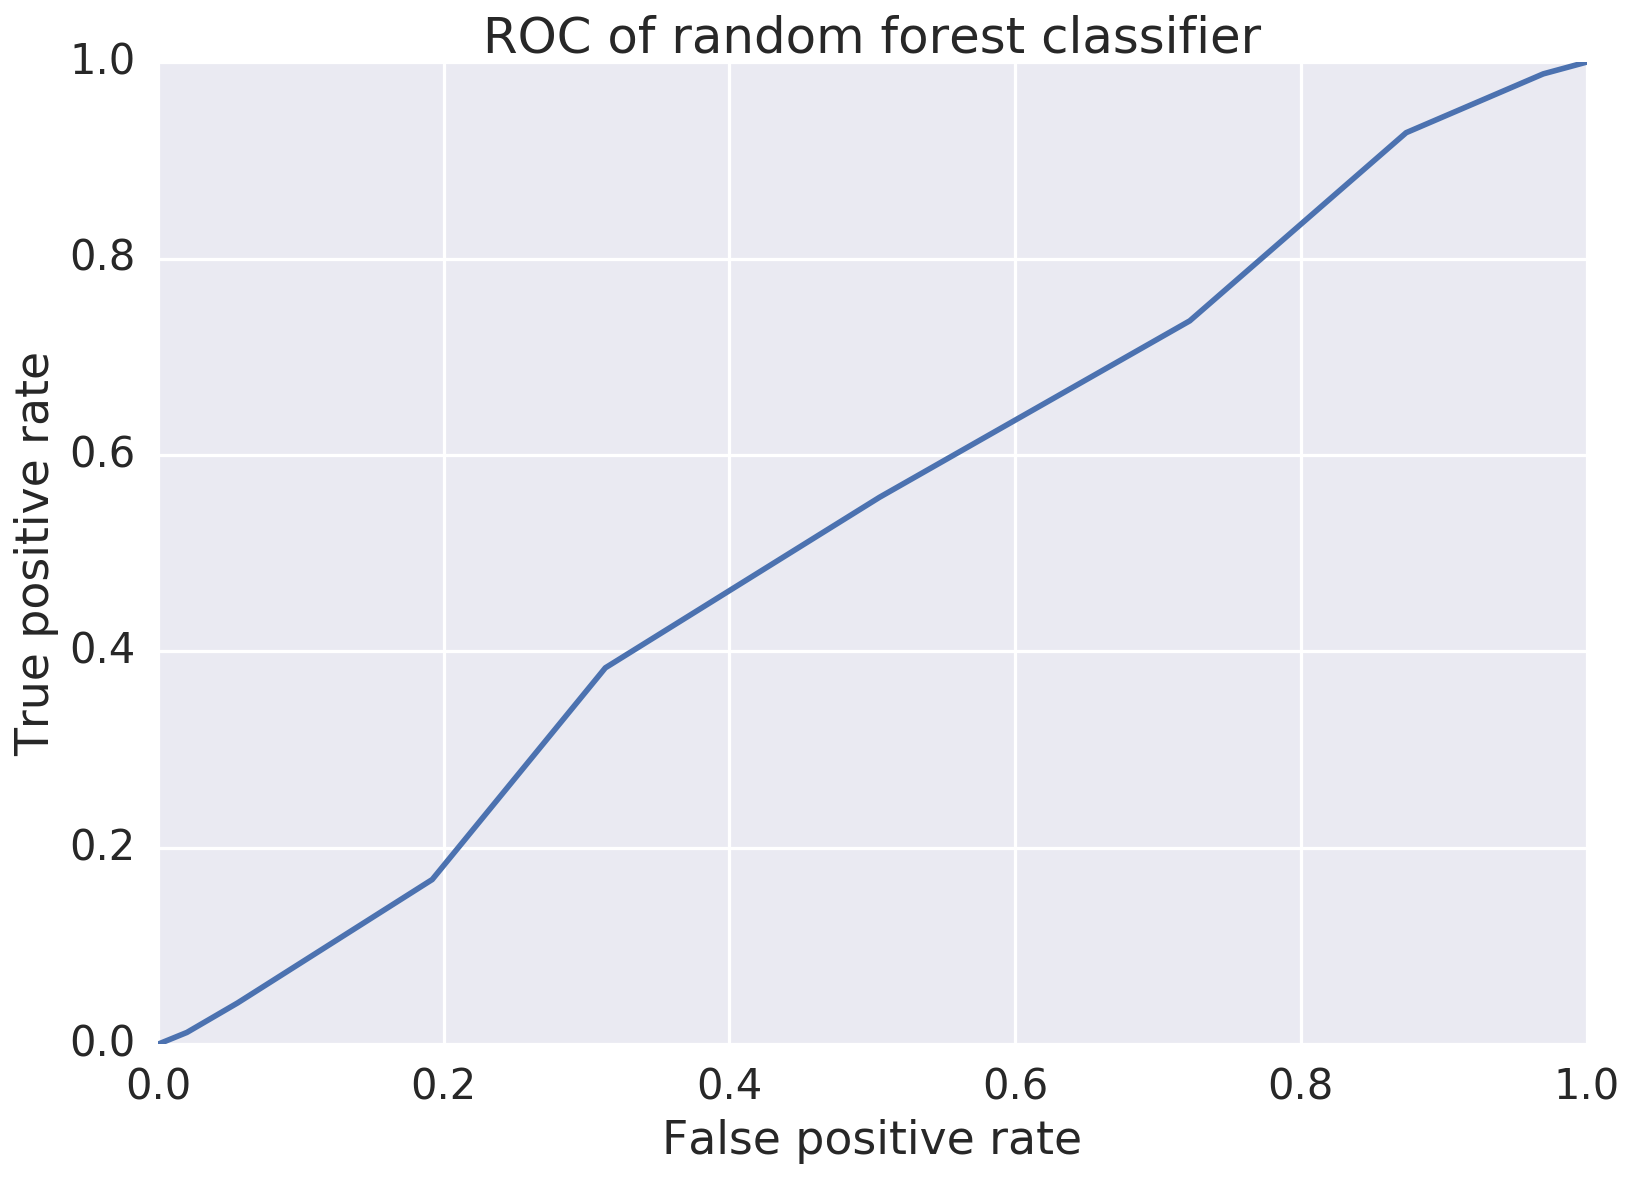

In [42]:
plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.savefig("./random_forest_roc.png")
plt.title("ROC of random forest classifier")
print("Area under curve is {}".format(metrics.auc(fpr, tpr)))

## Predict when an accepted will be posted

In [43]:
good_q_a = q_a[~q_a.acceptedanswerid_x.isnull()]

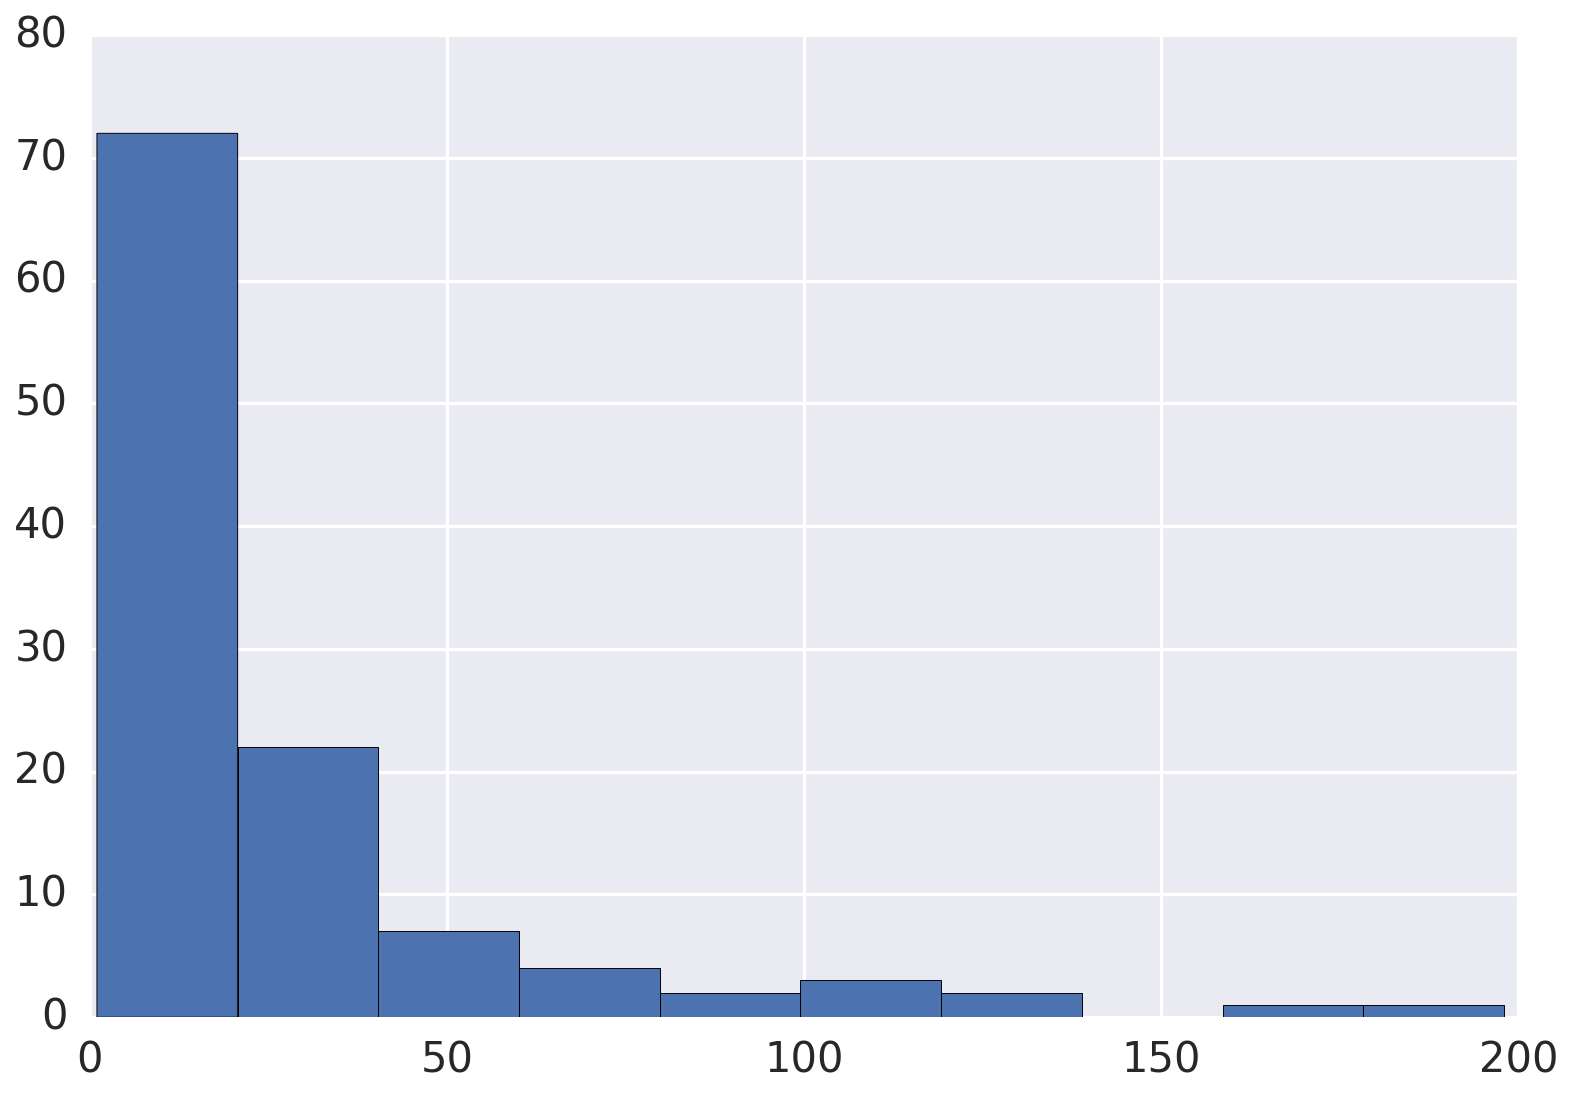

In [44]:
good_q_a.ElapsedTime.hist()

In [45]:
good_q_a.head(1)

,title_x,paragraphs_x,id_x,posttypeid_x,acceptedanswerid_x,creationdate_x,tags_x,parentid_x,codes_x,hasCodes_x,...,paragraphs_y,id_y,posttypeid_y,acceptedanswerid_y,creationdate_y,tags_y,parentid_y,codes_y,hasCodes_y,ElapsedTime
12,I dont know why my code is keep on getting an ...,It keeps on saying\nHow can I fix it?,35821482,1,3.58215e+07,2016-03-06 00:07:00.347,python,NaN,"def square(10):\n """"""returns the square of ...",1,...,You used the literal 10 where you should have ...,35821495,2,NaN,2016-03-06 00:09:06.070,None,3.58215e+07,"10\ndef square(x):\n """"""returns the square ...",1,2.0


In [46]:
X = good_q_a[['title_x', 'paragraphs_x', 'tags_x', 'hasCodes_x']]
X.columns = ['title', 'paragraphs', 'tags', 'hasCodes']
y = good_q_a.ElapsedTime

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
pipeline = Pipeline(feature_union + [
#        ('to_dense', DenseTransformer()),
        ('reg', LinearRegression(n_jobs=4)),
    ])

In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('title', Pipeline(steps=[('selector', ItemSelector(key='title')), ('tfidf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lower...le': 0.33})), ('reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False))])

In [ ]:
y = pipeline.predict(X_test)

In [ ]:
mean_absolute_error(y, y_test)

In [ ]:
joblib.dump(pipeline, "./linear_regression.pkl")

# Votes
- Id
- PostId
- VoteTypeId (listed in the VoteTypes table)
  1. AcceptedByOriginator
  2. UpMod (AKA upvote)
  3. DownMod (AKA downvote)
  4. Offensive
  5. Favorite (UserId will also be populated)
  6. Close (since 2013-06-25 close votes are ONLY stored in the PostHistory table)
  7. Reopen
  8. BountyStart (UserId and BountyAmount will also be populated)
  9. BountyClose (BountyAmount will also be populated)
  10. Deletion
  11. Undeletion
  12. Spam
  15. ModeratorReview
  16. ApproveEditSuggestion
- UserId (only present if VoteTypeId is 5 or 8)
- CreationDate (time data is purposefully removed to protect user privacy)
- BountyAmount (only present if VoteTypeId is 8 or 9)

In [ ]:
sql_query = """
SELECT * FROM votes
where creationdate > '2008-07-01'
limit 10;
"""
votes = pd.read_sql_query(sql_query, con)

In [ ]:
votes

# Users

- Id
- Reputation
- CreationDate
- DisplayName
- LastAccessDate
- WebsiteUrl
- Location
- AboutMe
- Views
- UpVotes (how many upvotes the user has cast)
- DownVotes
- EmailHash (now always blank)
- AccountId (StackExchange Network profile Id of the user)
- Age

In [ ]:
sql_query = """
SELECT * FROM users limit 2;
"""
users= pd.read_sql_query(sql_query, con)

In [ ]:
users

## TODO Remove the user with id = -1

# Tags
- Id
- TagName
- Count
- ExcerptPostId
- WikiPostId

In [ ]:
sql_query = """
SELECT * FROM tags limit 2;
"""
tags = pd.read_sql_query(sql_query, con)

In [ ]:
tags

# Badges
- Id
- UserId, e.g.: "420"
- Name, e.g.: "Teacher"
- Date, e.g.: "2008-09-15T08:55:03.923"
- Class
- Gold
- Silver
- Bronze
- TagBased, true if badge is for a tag, otherwise it is a named badge

In [ ]:
sql_query = """
SELECT * FROM badges limit 2;
"""
badges = pd.read_sql_query(sql_query, con)

In [ ]:
badges

In [ ]:
sql_query = """
SELECT * FROM badges where userid = 3718;
"""
badges = pd.read_sql_query(sql_query, con)

In [ ]:
badges